<a href="https://colab.research.google.com/github/PJL-Emily/ethnicity-classification-by-name/blob/main/gender_prediction_olympic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
import io
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import unicodedata as ud
import copy
import random
import matplotlib.pyplot as plt
import tqdm
import torch


from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Activation, Dense, Dot, Embedding, Flatten, GlobalAveragePooling1D, Reshape, Input, Conv1D, MaxPooling1D, concatenate, Dropout
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from keras.optimizers import Adam
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE, ADASYN

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
%cd /content/drive/Shareddrives/weilao_research/olympic

/content/drive/Shareddrives/weilao_research/olympic


In [ ]:
athlete = pd.read_csv('./data/athlete_events.csv')
display(athlete)

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271111,135569,Andrzej ya,M,29.0,179.0,89.0,Poland-1,POL,1976 Winter,1976,Winter,Innsbruck,Luge,Luge Mixed (Men)'s Doubles,NaN
271112,135570,Piotr ya,M,27.0,176.0,59.0,Poland,POL,2014 Winter,2014,Winter,Sochi,Ski Jumping,"Ski Jumping Men's Large Hill, Individual",NaN
271113,135570,Piotr ya,M,27.0,176.0,59.0,Poland,POL,2014 Winter,2014,Winter,Sochi,Ski Jumping,"Ski Jumping Men's Large Hill, Team",NaN
271114,135571,Tomasz Ireneusz ya,M,30.0,185.0,96.0,Poland,POL,1998 Winter,1998,Winter,Nagano,Bobsleigh,Bobsleigh Men's Four,NaN


# Getting Unique Values

In [ ]:
def uniqueIndices(df):
    seen = set()
    res = []
    for i, n in enumerate(df['Name']):
        if n not in seen:
            res.append(i)
            seen.add(n)
    return res

In [ ]:
indices = uniqueIndices(athlete)
athlete = athlete.iloc[indices, :].reset_index(drop = True)

In [ ]:
display(athlete)

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134727,135567,Aleksandr Viktorovich Zyuzin,M,24.0,183.0,72.0,Russia,RUS,2000 Summer,2000,Summer,Sydney,Rowing,Rowing Men's Lightweight Coxless Fours,NaN
134728,135568,Olga Igorevna Zyuzkova,F,33.0,171.0,69.0,Belarus,BLR,2016 Summer,2016,Summer,Rio de Janeiro,Basketball,Basketball Women's Basketball,NaN
134729,135569,Andrzej ya,M,29.0,179.0,89.0,Poland-1,POL,1976 Winter,1976,Winter,Innsbruck,Luge,Luge Mixed (Men)'s Doubles,NaN
134730,135570,Piotr ya,M,27.0,176.0,59.0,Poland,POL,2014 Winter,2014,Winter,Sochi,Ski Jumping,"Ski Jumping Men's Large Hill, Individual",NaN


Text(0.5, 1.0, 'Bar chart')

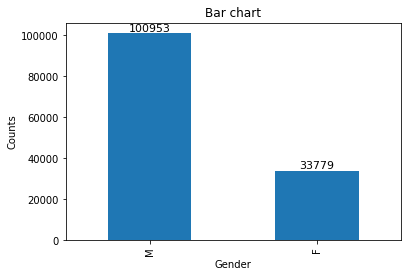

In [ ]:
X = [0,1,2,3,4,5,6,7,8,9,10]
gender_counts = athlete['Sex'].value_counts()
mapping_bar_chart = gender_counts.plot.bar()

#使用text顯示數值  
for a,b in zip(X,gender_counts):  
  plt.text(a, b+0.05, '%.0f' % b, ha='center', va= 'bottom',fontsize=11) 

plt.xlabel('Gender')
plt.ylabel('Counts')
plt.title('Bar chart')

# Map Ethnicity

In [ ]:
muslim_countries = ['KAZ', 'AZE', 'UZB', 'TUR', 'TUN', 'MAR', 'ALG', 'LBA', 'EGY', 'SOM', 'SUD', 'SSD', \
            'UAE', 'IRQ', 'YEM', 'BRN', 'SYR', 'JOR', 'OMA', 'LBN', 'QAT', 'KUW', 'KSA', \
            'BAN', 'PAK', 'IRI', 'AFG']
european_countries = ['CZE', 'SVK', 'HUN', 'POL', 'BIH', 'SRB', 'SLO', 'MNE', 'BUL', 'CRO', 'MKD', \
            'GER', 'AUT', 'NED', 'SUI', 'BEL', 'FRA', \
            'LAT', 'EST', 'LTU', 'RUS', 'BLR', 'UKR', 'ROU', 'ITA', 'URS']
african_countries = ['CGO', 'COD', 'LBR', 'SEN', 'SLE', 'GBS', 'GEQ', 'GUI', 'PNG', \
            'ZAM', 'RWA', 'TAN', 'KEN', 'SSD', 'ETH', 'UGA', \
            'BOT', 'NAM', 'ZIM', 'RSA']
eastasian_countries = ['CAM', 'THA', 'MYA', 'VIE', 'INA', 'MAS', \
             'SGP', 'HKG', 'CHN', 'TPE', 'KOR', 'JPN']
southasian_countries = ['NEP', 'IND', 'SRI']
hispanic_countries = ['DOM', 'DMA', 'URU', 'GUA', 'COL', 'VEN', 'CHI', 'PAN', \
            'BOL', 'ESA', 'ECU', 'ARG', 'HON', 'HBR', 'BIZ', 'PER', 'CRC', \
            'PAR', 'MEX', 'ESP', 'NCA', 'POR', 'BRA', 'ANG', 'MOZ', 'PHI']
nordic_countries = ['DEN', 'SWE', 'NOR', 'FIN']

In [ ]:
def NOC_to_ethnicity(noc):
  if (noc in muslim_countries):
    return 'muslim'
  if (noc in european_countries):
    return 'european'
  if (noc in african_countries):
    return 'african'
  if (noc in eastasian_countries):
    return 'eastasian'
  if (noc in southasian_countries):
    return 'southasian'
  if (noc in hispanic_countries):
    return 'hispanic'
  if (noc in nordic_countries):
    return 'nordic'
  if (noc == 'GBR' or noc == 'IRL'):
    return 'celticenglish'
  if (noc == 'ISR'):
    return 'jewish'
  if (noc == 'GRE'):
    return 'greece'
  return 'other'

In [ ]:
athlete['ethnicity'] = athlete['NOC'].apply(lambda m: NOC_to_ethnicity(m))
display(athlete.head())

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,ethnicity
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN,eastasian
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN,eastasian
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN,nordic
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold,nordic
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN,european


# Drop Low Frequency Ethnicities

In [ ]:
for ethnicity in ['other', 'african', 'greece', 'southasian', 'jewish']:
  indices = athlete[(athlete['ethnicity'] == ethnicity)].index
  athlete.drop(indices, inplace=True)
athlete = athlete.reset_index(drop=True)
display(athlete)

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,ethnicity
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN,eastasian
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN,eastasian
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN,nordic
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold,nordic
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN,european
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92964,135567,Aleksandr Viktorovich Zyuzin,M,24.0,183.0,72.0,Russia,RUS,2000 Summer,2000,Summer,Sydney,Rowing,Rowing Men's Lightweight Coxless Fours,NaN,european
92965,135568,Olga Igorevna Zyuzkova,F,33.0,171.0,69.0,Belarus,BLR,2016 Summer,2016,Summer,Rio de Janeiro,Basketball,Basketball Women's Basketball,NaN,european
92966,135569,Andrzej ya,M,29.0,179.0,89.0,Poland-1,POL,1976 Winter,1976,Winter,Innsbruck,Luge,Luge Mixed (Men)'s Doubles,NaN,european
92967,135570,Piotr ya,M,27.0,176.0,59.0,Poland,POL,2014 Winter,2014,Winter,Sochi,Ski Jumping,"Ski Jumping Men's Large Hill, Individual",NaN,european


In [ ]:
ethnicity_percent = athlete['ethnicity'].value_counts(normalize=True)*100
display(ethnicity_percent)

european         48.306425
hispanic         14.239155
eastasian        11.972808
nordic           11.027332
celticenglish     7.572417
muslim            6.881864
Name: ethnicity, dtype: float64

## Distribution Bar Chart

Text(0.5, 1.0, 'Bar chart')

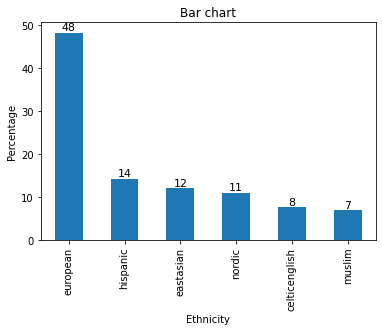

In [ ]:
# mapping_bar_chart = ethnicity_percent.plot.bar()

X = [0,1,2,3,4,5,6,7,8,9]
mapping_bar_chart = ethnicity_percent.plot.bar()

#使用text顯示數值  
for a,b in zip(X,ethnicity_percent):  
  plt.text(a, b+0.05, '%.0f' % b, ha='center', va= 'bottom',fontsize=11) 

plt.xlabel('Ethnicity')
plt.ylabel('Percentage')
plt.title('Bar chart')

In [ ]:
athlete_s = athlete.groupby(['ethnicity', 'Sex']).count()
athlete_s

ID   Name    Age  Height  ...   City  Sport  Event  Medal
ethnicity     Sex                               ...                            
celticenglish F     1713   1713   1677    1406  ...   1713   1713   1713    159
              M     5327   5327   4782    2838  ...   5327   5327   5327    934
eastasian     F     4033   4033   4025    3792  ...   4033   4033   4033    646
              M     7098   7098   6853    6017  ...   7098   7098   7098    619
european      F    11315  11315  11189   10084  ...  11315  11315  11315   1583
              M    33595  33595  31267   22408  ...  33595  33595  33595   5278
hispanic      F     2816   2816   2796    2499  ...   2816   2816   2816    186
              M    10422  10422   9816    7739  ...  10422  10422  10422    688
muslim        F      971    971    966     888  ...    971    971    971     32
              M     5427   5427   4767    4058  ...   5427   5427   5427    271
nordic        F     1895   1895   1895    1560  ...   1895   1895   1895    273
              M     8357   8357   8347    4811  ...   8357   8357   8357   1594

[12 rows x 14 columns]

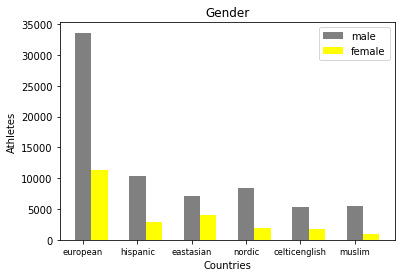

In [ ]:
bar_width = 0.3

countries = ['european', 'hispanic', 'eastasian', 'nordic', 'celticenglish', 'muslim']
males = [33595, 10422, 7098, 8357, 5327, 5427]
females = [11315, 2816, 4033, 1895, 1713, 971]

# [0, 1, 2, 3, 4, 5, 6]
m_xpos = [i for i, _ in enumerate(countries)]
# [0.4, 1.4, 2.4, 3.4, 4.4, 5.4, 6.4]
f_xpos = [val + bar_width for val in m_xpos]

plt.xlabel('Countries')
plt.ylabel('Athletes')
plt.title('Gender')

plt.bar(m_xpos, males, label='male', width=bar_width, color='grey')
plt.bar(f_xpos, females, label='female', width=bar_width, color='yellow')
plt.xticks(range(len(countries)), countries, size='small')

plt.legend()
plt.show()

# Map EASCII to ASCII

In [ ]:
def replace_symbols(value):
    # 處理()內綽號的刪除
    # print(value)
    new_name = value
    while new_name.find('(') != -1: # 可能有複數個()組合
        first = new_name.find('(')
        front = new_name[:new_name.find('(')]
        back = new_name[new_name.find(')') + 1:]
        new_name = front + back
    # print(new_name)

    # 處理""內綽號的刪除
    new_name2 = new_name
    while new_name2.find('"') != -1: # 可能有複數個""組合
        first = new_name2.find('"')
        if new_name2.find('"', first + 1) != -1:
            front = new_name2[:first - 1]
            back = new_name2[new_name2.find('"', first + 1) + 1:]
            new_name2 = front + back
        else: # 有些名字會單獨存在" e.g. Lala "nana
            new_name2 = new_name2.replace('"', '')
    # print(new_name2)

    # 將- /換成space，`&,刪掉
    name_s = new_name2.replace("-", " ")
    name_s = name_s.replace("`", "")
    name_s = name_s.replace("/", " ")
    name_s = name_s.replace("&", "")
    name_s = name_s.replace(",", "")
    name_s = name_s.replace(")", "")

    name_list = name_s.split(" ")
    if "" in name_list:
        name_list.remove("")
    # print(name_list)

    # 目前先選擇最後一個詞用+包
    n = len(name_list)
    temp = ["" for i in range(n)]
    result = ""
    for i in range(n):
        temp[i] = "$" + name_list[i] + "$"
        result = result + temp[i]

    return result

def get_ascii_char(c):
    s = ud.decomposition(c)
    if s == '': # for an indecomposable character, it returns ''
        return c
    code = int('0x' + s.split()[0], 0)
    return chr(code)

def translater(name):
    name_clean = replace_symbols(name)
    name_EG = ""
    for letter in name_clean:
        name_EG += get_ascii_char(letter).lower()
    return name_EG


In [ ]:
athlete_name = list(copy.deepcopy(athlete['Name']))
print("Number of names: ", len(athlete_name))

Number of names:  92969


In [ ]:
n = len(athlete_name)
english_name = ["" for i in range(n)]
for i in range(len(athlete_name)): # len(athlete_name)
    english_name[i] = translater(athlete_name[i])
print(len(english_name))
print(english_name[0:5])

92969
['$a$$dijiang$', '$a$$lamusi$', '$gunnar$$nielsen$$aaby$', '$edgar$$lindenau$$aabye$', '$christine$$jacoba$$aaftink$']


## Bi-gram precessing

In [ ]:
def bigram(aName):
  n = len(aName)
  grams = ['' for i in range(n-1)]
  for i in range(n-1):
    grams[i] = aName[i:(i+2)]
  # print(grams)
  return grams

def bigramProcessor(names):
  n = len(names)
  data = [[] for i in range(n)]
  for i in range(n):
    data[i] = bigram(names[i])
  return data

In [ ]:
bi_name = bigramProcessor(english_name)

In [ ]:
print(bi_name[0])

['$a', 'a$', '$$', '$d', 'di', 'ij', 'ji', 'ia', 'an', 'ng', 'g$']


## Bi-gram Length Histogram

In [ ]:
total = len(bi_name)
l = [len(bi_name[i]) for i in range(len(bi_name))]
l.sort()
MAX_SEQUENCE_LENGTH = 30

(array([1.1872e+04, 5.6349e+04, 2.1004e+04, 3.3460e+03, 3.0700e+02,
        5.9000e+01, 2.2000e+01, 5.0000e+00, 3.0000e+00, 2.0000e+00]),
 array([  3. ,  13.6,  24.2,  34.8,  45.4,  56. ,  66.6,  77.2,  87.8,
         98.4, 109. ]),
 <a list of 10 Patch objects>)

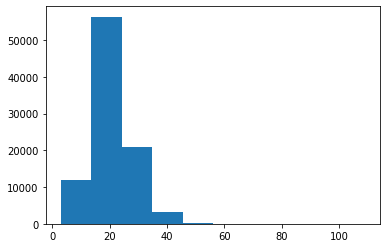

In [ ]:
plt.hist(l)

## Character Representation (Skip Gram)

In [ ]:
def Biname2sequence(bi_name):
  vocab, index = {}, 1 # start indexing from 1
  vocab['<pad>'] = 0 # add a padding token 
  for name in bi_name:
    for bigram in name:
      if bigram not in vocab: 
        vocab[bigram] = index # word to id
        index += 1
  vocabulary = list(vocab.keys())
  inverse_vocab = {index: token for token, index in vocab.items()} # id to word
  print("vocabulary size =",len(vocabulary))
  sequence = [] # bi-gram name list to id list
  for name in bi_name:
    temp = []
    for bigram in name:
      temp.append(vocab[bigram])
    if len(temp) < MAX_SEQUENCE_LENGTH:
      while len(temp) < MAX_SEQUENCE_LENGTH:
        temp.append(0)
    elif len(temp) > MAX_SEQUENCE_LENGTH:
        temp = temp[:30]
    sequence.append(temp)
  for i in range(1):
    print(''.join('{} len = {}'.format(sequence[i], len(sequence[i]))))
  return vocab, vocabulary, inverse_vocab, sequence

# construct skip-gram embedding model
class Word2Vec(Model):
  def __init__(self, vocab_size, embedding_dim, num_ns):
    super(Word2Vec, self).__init__()
    self.target_embedding = Embedding(vocab_size, 
                      embedding_dim,
                      input_length=1,
                      name="w2v_embedding", )
    self.context_embedding = Embedding(vocab_size, 
                      embedding_dim, 
                      input_length=num_ns+1)
    self.dots = Dot(axes=(3,2))
    self.flatten = Flatten()

  def call(self, pair):
    target, context = pair
    we = self.target_embedding(target)
    ce = self.context_embedding(context)
    dots = self.dots([ce, we])
    return self.flatten(dots)

# Generates skip-gram pairs with negative sampling for a list of sequences
# (int-encoded sentences) based on window size, number of negative samples
# and vocabulary size.
def generate_training_data(sequences, window_size, num_ns, vocab_size, seed):
  tf.random.set_seed(seed)
  # Elements of each training example are appended to these lists.
  targets, contexts, labels = [], [], []

  # Build the sampling table for vocab_size tokens.
  sampling_table = tf.keras.preprocessing.sequence.make_sampling_table(vocab_size)

  # Iterate over all sequences (sentences) in dataset.
  for sequence in tqdm.tqdm(sequences):

    # Generate positive skip-gram pairs for a sequence (sentence).
    positive_skip_grams, _ = tf.keras.preprocessing.sequence.skipgrams(
          sequence, 
          vocabulary_size=vocab_size,
          sampling_table=sampling_table,
          window_size=window_size,
          negative_samples=0,
          seed=seed)
    
    # Iterate over each positive skip-gram pair to produce training examples 
    # with positive context word and negative samples.
    for target_word, context_word in positive_skip_grams:
      context_class = tf.expand_dims(
          tf.constant([context_word], dtype="int64"), 1)
      negative_sampling_candidates, _, _ = tf.random.log_uniform_candidate_sampler(
          true_classes=context_class,
          num_true=1, 
          num_sampled=num_ns, 
          unique=True, 
          range_max=vocab_size, 
          seed=seed, 
          name="negative_sampling")
      # Build context and label vectors (for one target word)
      negative_sampling_candidates = tf.expand_dims(
          negative_sampling_candidates, 1)

      context = tf.concat([context_class, negative_sampling_candidates], 0)
      label = tf.constant([1] + [0]*num_ns, dtype="int64")

      # Append each element from the training example to global lists.
      targets.append(target_word)
      contexts.append(context)
      labels.append(label)

  return targets, contexts, labels

def SkipGram(targets, contexts, labels, vocab_size, num_ns, embedding_dim, seed):  
  # construct dataset of bi-gram
  dataset = tf.data.Dataset.from_tensor_slices(((targets, contexts), labels))
  dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=False)
  dataset = dataset.cache().prefetch(buffer_size=AUTOTUNE)

  word2vec = Word2Vec(vocab_size=vocab_size, embedding_dim=embedding_dim, num_ns=num_ns)
  word2vec.compile(optimizer='adam',
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")
  word2vec.fit(dataset, epochs=10, callbacks=[tensorboard_callback])

  weights = word2vec.get_layer('w2v_embedding').get_weights()[0]

  out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
  for index, word in enumerate(vocabulary):
    vec = weights[index] 
    out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_v.close()
  return weights

In [ ]:
vocab, vocabulary, inverse_vocab, sequence = Biname2sequence(bi_name)

vocabulary size = 767
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len = 30


In [ ]:
isSave = False
MYSEED = 1126
embedding_dim = 256
BATCH_SIZE = 64

if not isSave:
  window_size = 5
  num_ns = 5
  targets, contexts, labels = generate_training_data(
                        sequences=sequence,
                        window_size=window_size,
                        num_ns=num_ns,
                        vocab_size=len(vocab),
                        seed=MYSEED)
  
  tf.random.set_seed(MYSEED)
  AUTOTUNE = tf.data.AUTOTUNE
  BUFFER_SIZE = 10000

  weights = SkipGram(targets, contexts, labels, len(vocab), num_ns, embedding_dim, MYSEED)
else:
  weights = []
  file = open('vectors.tsv', 'r', encoding='utf-8')
  for line in file:
    temp_values = line.split()
    values = [float(temp_values[i]) for i in range(len(temp_values))]
    coefs = np.asarray(values, dtype='float32')
    weights.append(coefs)
  file.close()
  

100%|██████████| 92969/92969 [01:51<00:00, 834.54it/s]


Epoch 1/10
19521/19521 [==============================] - 122s 6ms/step - loss: 1.0851 - accuracy: 0.5870
Epoch 2/10
19521/19521 [==============================] - 137s 7ms/step - loss: 0.9625 - accuracy: 0.6351
Epoch 3/10
19521/19521 [==============================] - 141s 7ms/step - loss: 0.9501 - accuracy: 0.6390
Epoch 4/10
19521/19521 [==============================] - 140s 7ms/step - loss: 0.9434 - accuracy: 0.6409
Epoch 5/10
19521/19521 [==============================] - 142s 7ms/step - loss: 0.9391 - accuracy: 0.6420
Epoch 6/10
19521/19521 [==============================] - 140s 7ms/step - loss: 0.9361 - accuracy: 0.6425
Epoch 7/10
19521/19521 [==============================] - 141s 7ms/step - loss: 0.9342 - accuracy: 0.6428
Epoch 8/10
19521/19521 [==============================] - 141s 7ms/step - loss: 0.9332 - accuracy: 0.6429
Epoch 9/10
19521/19521 [==============================] - 144s 7ms/step - loss: 0.9326 - accuracy: 0.6430
Epoch 10/10
19521/19521 [=====================

In [ ]:
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.manifold import TSNE

distance_matrix = euclidean_distances(weights)
similar_words = {search_term: [inverse_vocab[idx] for idx in distance_matrix[vocab[search_term]].argsort()[1:6]] 
                   for search_term in vocabulary[0:5]}
similar_words

{'$$': ["'z", 'wv', 'qs', "h'", 'cf'],
 '$a': ['xc', 'vj', "q'", "'p", 'yx'],
 '$d': ['.f', 'vv', 'x.', 'xk', "'l"],
 '<pad>': ['yj', "h'", 'jp', 'vv', 'fw'],
 'a$': ['vv', "'z", '.f', 'wv', 'xm']}

## Plot Embedded Bi-grams

Total words: 30 	Word Embedding shapes: (30, 256)
['<pad>', 'yj', "h'", 'jp', 'vv', 'fw', '$a', 'xc', 'vj', "q'", "'p", 'yx', 'a$', 'vv', "'z", '.f', 'wv', 'xm', '$$', "'z", 'wv', 'qs', "h'", 'cf', '$d', '.f', 'vv', 'x.', 'xk', "'l"]


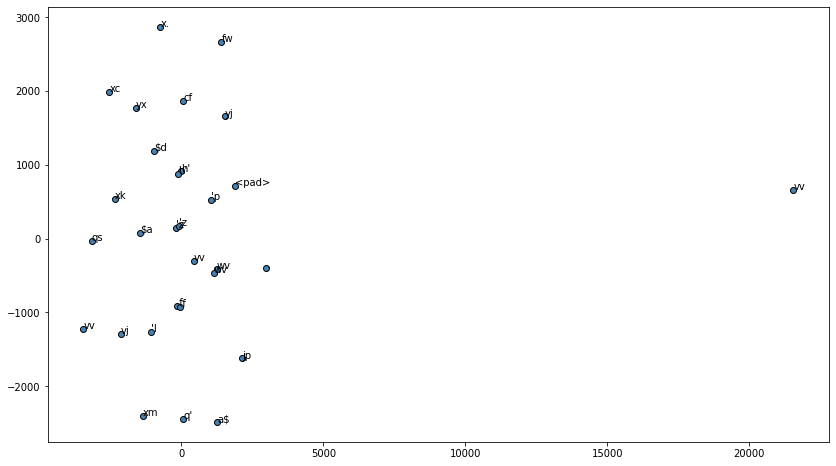

In [ ]:
words = sum([[k] + v for k, v in similar_words.items()], [])
words_ids = [vocab[w] for w in words]
word_vectors = np.array([weights[idx] for idx in words_ids])
print('Total words:', len(words), '\tWord Embedding shapes:', word_vectors.shape)

tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=0)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(word_vectors)
print(words)
plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='steelblue', edgecolors='k')
for label, x, y in zip(words, T[:, 0], T[:, 1]):
    if label == "$$":
        label = "$.$"
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

In [ ]:
for i in range(5):
  print(inverse_vocab[i], ":", weights[i][0:5], "...len =", len(weights[i]))

<pad> : [ 0.02777114 -0.00449574 -0.00299283  0.03505361  0.04536534] ...len = 256
$a : [-0.10540069 -0.52596956 -0.20181979  1.0633808   0.0380748 ] ...len = 256
a$ : [ 0.1619413   0.01532525  0.01756983 -0.53152573 -0.4017242 ] ...len = 256
$$ : [-0.05850507 -0.08836088 -0.12491047 -0.18418656 -0.0527864 ] ...len = 256
$d : [ 0.04981504  0.64851135  0.03737702 -0.09430211  0.39533377] ...len = 256


## Construct Training Dataset

In [ ]:
index_test = list(set(range(len(bi_name)))- set(index_train))
print(len(index_test))

NameError: ignored

In [ ]:
random.seed(MYSEED)
tf.random.set_seed(MYSEED)
tf.compat.v1.set_random_seed(MYSEED)
np.random.seed(MYSEED)
AUTOTUNE=tf.data.AUTOTUNE

train_num = int(len(bi_name)*0.8)
index_train = []
while len(index_train) != train_num:
  id = random.randint(1, len(bi_name))
  if id not in index_train:
    index_train.append(id)

bi_name_train = []
bi_name_test = []
gender_train = []
gender_test = []
gender = athlete['Sex'].tolist()
print(gender)

for i in range(len(gender)):
  if i in index_train:
    bi_name_train.append(bi_name[i])
    gender_train.append(gender[i])
  else:
    bi_name_test.append(bi_name[i])
    gender_test.append(gender[i])

In [ ]:
print(len(bi_name_train))
print(len(gender_train))

In [ ]:
ETH_DIM = 2
def constructDataset(raw_biGrams, raw_ethnicity): # input: 2 lists
  # X
  print("bigram num: ", len(raw_biGrams))
  print("max sequence length: ", MAX_SEQUENCE_LENGTH)
  X = np.zeros((len(raw_biGrams), MAX_SEQUENCE_LENGTH))
  for i in range(len(raw_biGrams)):
    pad = False
    for j in range(MAX_SEQUENCE_LENGTH):
      X[i][j] = vocab[raw_biGrams[i][j]]
      if j == len(raw_biGrams[i]) - 1 and j < MAX_SEQUENCE_LENGTH:
        pad = True
        break
    if pad == True:
      j = len(raw_biGrams[i])
      while j < MAX_SEQUENCE_LENGTH:
          X[i][j] = vocab['<pad>']
          j += 1
    
  # y
  y = np.zeros((len(raw_biGrams), ETH_DIM))
  for i in range(len(raw_ethnicity)):
    if raw_ethnicity[i] == 'M':
      y[i][0] = 1
    elif raw_ethnicity[i] == 'F':
      y[i][1] = 1
  
  # convert to tensor
  X_tensor = tf.convert_to_tensor(X, dtype=tf.int64)
  y_tensor = tf.convert_to_tensor(y, dtype=tf.int64)
  return X_tensor, y_tensor

In [ ]:
X_train, y_train = constructDataset(bi_name_train, gender_train)
X_test, y_test = constructDataset(bi_name_test, gender_test)

# Building Model

## Embedding

In [ ]:
def embedding_layer(weights, embedding_dim):
  embedding_index = weights
  embedding_matrix = np.zeros((len(embedding_index)+1, embedding_dim))
  for i in range(len(embedding_index)):
      embedding_matrix[i] = embedding_index[i]
  embeddingLayer = Embedding(len(embedding_index)+1,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)
  return embeddingLayer

## LSTM Model

In [ ]:
def LSTM_model(weights, embedding_dim, activate_lstm, activate_out, dropout, ETH_DIM, learning_rate):
  model = tf.keras.Sequential()
  model.add(embedding_layer(weights, embedding_dim))
  model.add(tf.keras.layers.LSTM(activation=activate_lstm, units=embedding_dim, dropout=dropout))
  model.add(Dense(units=ETH_DIM, activation=activate_out))
  model.compile(optimizer=Adam(lr=learning_rate), loss="categorical_crossentropy", metrics=["categorical_accuracy"])
  return(model)
  

# Training

## Parameter Notes

In [ ]:
EPOCH_NUM = 4
# BATCH_SIZE = 1024 use skip-gram parameter
activate_lstm = 'relu'
activate_out = 'softmax'
dropout = 0.5
learning_rate = 0.0035
lstm_model = LSTM_model(weights, embedding_dim, activate_lstm, activate_out, dropout, ETH_DIM, learning_rate)
lstm_model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, validation_split=0.2)

# Testing

In [ ]:
def lstm_testing(X_test, y_test):
  score = lstm_model.evaluate(X_test, y_test)
  print("Test result:", score)

  y_test_oneHot = np.argmax(y_test, axis=1) # Convert one-hot to index
  y_pred = lstm_model.predict_classes(X_test)
  print(classification_report(y_test_oneHot, y_pred))
  return y_pred

In [ ]:
test_pre = lstm_testing(X_test, y_test)

## Plot Prediction

In [ ]:
pred = lstm_model.predict(X_test)

In [ ]:
def plot_confusionHeatmap(pred, y_real): # one-hot encoded
  pred_arr = [0 for i in range(len(pred))]
  y_real_arr = [0 for i in range(len(y_real))]
  print("pred len: ", len(pred))
  print("y_real len: ", len(y_real))
  for i in range(len(pred)): # to numPy
    pred_arr[i] = np.argmax(pred[i])
    y_real_np = y_real.numpy()
    # y_real_np = y_real
    y_real_arr[i] = np.argmax(y_real_np[i])
  
  confusion_mat = tf.math.confusion_matrix(pred_arr, y_real_arr) # row: real, col: pred
  confusion_mat = confusion_mat.numpy()
  labels = ["Male", "Female"]

  fig, ax = plt.subplots()
  im = ax.imshow(confusion_mat)

  # show all ticks
  ax.set_xticks(np.arange(len(labels)))
  ax.set_yticks(np.arange(len(labels)))
  # ... and label them with the respective list entries
  ax.set_xticklabels(labels)
  ax.set_yticklabels(labels)

  # Rotate the tick labels and set their alignment.
  plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
          rotation_mode="anchor")

  # Loop over data dimensions and create text annotations.
  for i in range(len(labels)):
      for j in range(len(labels)):
          text = ax.text(j, i, confusion_mat[i, j],
                        ha="center", va="center", color="w")

  ax.set_title("Confusion Matrix For Model")
  ax.set_xlabel('Predicted Label')
  ax.set_ylabel('Real Label')
  fig.tight_layout()
  plt.show()

In [ ]:
labels = 'M','F'
sizes = pred[5678]
print(sizes)
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.axis('equal')
plt.show()

In [ ]:
index_test.sort()
id = index_test[5678]
print(athlete.loc[id-1])

In [ ]:
plot_confusionHeatmap(pred, y_train) # 怎麼用ㄚ